In [1]:
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import itertools
from sklearn.metrics import *
%matplotlib inline

Load Data

In [2]:
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")
sub = pd.read_csv("sample_submission.csv")

In [3]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


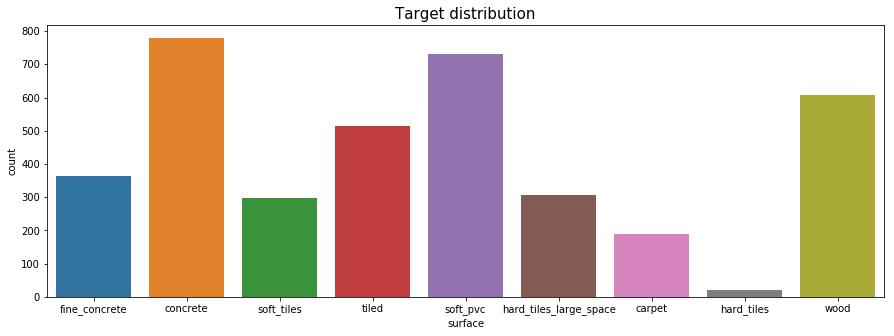

In [4]:
plt.figure(figsize=(15, 5))
sns.countplot(y_train['surface'])
plt.title('Target distribution', size=15)
plt.show()

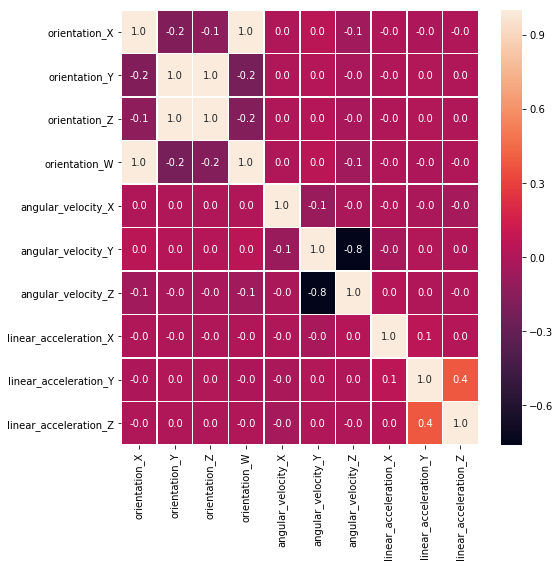

In [5]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(X_train.iloc[:,3:].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

### Feature Engineering

In [6]:
def fe(data):
    
    df = pd.DataFrame()
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 +
                             data['angular_velocity_Z']**2)** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 +
                             data['linear_acceleration_Z'])**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 +
                             data['orientation_Z'])**0.5
   
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
    
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
    return df

In [7]:
%%time
X_train = fe(X_train)
X_test = fe(X_test)
print(X_train.shape)

(3810, 154)
Wall time: 3min 4s


In [8]:
X_train.head()

,orientation_X_mean,orientation_X_median,orientation_X_max,orientation_X_min,orientation_X_std,orientation_X_range,orientation_X_maxtoMin,orientation_X_mean_abs_chg,orientation_X_abs_max,orientation_X_abs_min,...,acc_vs_vel_median,acc_vs_vel_max,acc_vs_vel_min,acc_vs_vel_std,acc_vs_vel_range,acc_vs_vel_maxtoMin,acc_vs_vel_mean_abs_chg,acc_vs_vel_abs_max,acc_vs_vel_abs_min,acc_vs_vel_abs_avg
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.758530,-0.75822,-0.75953,0.000363,0.00131,0.998275,0.000015,0.75953,0.75822,...,58.553942,343.177292,9.862277,55.561178,333.315015,34.796964,NaN,343.177292,9.862277,176.519784
1,-0.958606,-0.958595,-0.95837,-0.95896,0.000151,0.00059,0.999385,0.000023,0.95896,0.95837,...,33.219737,183.869360,3.289625,30.676722,180.579735,55.893717,NaN,183.869360,3.289625,93.579492
2,-0.512057,-0.512035,-0.50944,-0.51434,0.001377,0.00490,0.990473,0.000041,0.51434,0.50944,...,38.743674,266.540888,3.284419,55.617389,263.256469,81.153132,NaN,266.540888,3.284419,134.912654
3,-0.939169,-0.939170,-0.93884,-0.93968,0.000227,0.00084,0.999106,0.000026,0.93968,0.93884,...,40.884091,436.616264,0.846487,70.014111,435.769777,515.797712,NaN,436.616264,0.846487,218.731376
4,-0.891301,-0.890940,-0.88673,-0.89689,0.002955,0.01016,0.988672,0.000080,0.89689,0.88673,...,15.313575,26.094889,0.580558,5.881548,25.514331,44.947934,NaN,26.094889,0.580558,13.337724


**Ouput**

We encode our targets

In [9]:
le = LabelEncoder()
y_train['surface'] = le.fit_transform(y_train['surface'])

## Modeling


K-Folds

In [10]:
X_train.fillna(0, inplace = True)
X_test.fillna(0, inplace = True)
X_train.replace(-np.inf, 0, inplace = True)
X_train.replace(np.inf, 0, inplace = True)
X_test.replace(-np.inf, 0, inplace = True)
X_test.replace(np.inf, 0, inplace = True)

In [11]:
def k_folds(X, y, X_test, k):
    folds = StratifiedKFold(n_splits = k, shuffle=True, random_state=2019)
    y_test = np.zeros((X_test.shape[0], 9))
    y_oof = np.zeros((X.shape[0]))
    score = 0
    for i, (train_idx, val_idx) in  enumerate(folds.split(X, y)):
        clf =  RandomForestClassifier(n_estimators = 500, n_jobs = -1)
        clf.fit(X_train.iloc[train_idx], y[train_idx])
        y_oof[val_idx] = clf.predict(X.iloc[val_idx])
        y_test += clf.predict_proba(X_test) / folds.n_splits
        score += clf.score(X.iloc[val_idx], y[val_idx])
        print('Fold: {} score: {}'.format(i,clf.score(X.iloc[val_idx], y[val_idx])))
    print('Avg Accuracy', score / folds.n_splits) 
        
    return y_oof, y_test 

In [12]:
y_oof, y_test = k_folds(X_train, y_train['surface'], X_test, k= 50)

C:\Anaconda3\envs\TFMagic\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 21 members, which is too few. The minimum number of members in any class cannot be less than n_splits=50.
  % (min_groups, self.n_splits)), Warning)


Fold: 0 score: 0.9506172839506173
Fold: 1 score: 0.875
Fold: 2 score: 0.9259259259259259
Fold: 3 score: 0.9
Fold: 4 score: 0.85
Fold: 5 score: 0.8625
Fold: 6 score: 0.9375
Fold: 7 score: 0.9113924050632911
Fold: 8 score: 0.8589743589743589
Fold: 9 score: 0.8607594936708861
Fold: 10 score: 0.9615384615384616
Fold: 11 score: 0.8860759493670886
Fold: 12 score: 0.8481012658227848
Fold: 13 score: 0.8846153846153846
Fold: 14 score: 0.9342105263157895
Fold: 15 score: 0.9210526315789473
Fold: 16 score: 0.8831168831168831
Fold: 17 score: 0.8552631578947368
Fold: 18 score: 0.9078947368421053
Fold: 19 score: 0.8831168831168831
Fold: 20 score: 0.8961038961038961
Fold: 21 score: 0.922077922077922
Fold: 22 score: 0.8831168831168831
Fold: 23 score: 0.8289473684210527
Fold: 24 score: 0.9090909090909091
Fold: 25 score: 0.8552631578947368
Fold: 26 score: 0.8571428571428571
Fold: 27 score: 0.9210526315789473
Fold: 28 score: 0.9342105263157895
Fold: 29 score: 0.9066666666666666
Fold: 30 score: 0.868421052

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_oof,y_train['surface'])

array([[156,   3,   0,   0,   2,   3,   2,   3,   0],
       [ 15, 697,  19,   1,  12,  17,   4,  22,  16],
       [  0,   9, 294,   0,   1,   5,   0,   3,   5],
       [  0,   0,   0,  10,   0,   0,   0,   0,   1],
       [  1,  13,   1,   0, 282,   4,   0,   2,   1],
       [  3,  16,   9,   0,   2, 675,   5,   8,  24],
       [  3,  10,   2,   2,   1,   9, 280,   3,   2],
       [  2,  10,  11,   0,   0,   2,   0, 463,  20],
       [  9,  21,  27,   8,   8,  17,   6,  10, 538]], dtype=int64)